In [1]:
import pandas as pd
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import datetime

#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.metrics import plot_confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from functions import all_models as m
from functions import plot_importances
from functions import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('csv/iPhoneTweets.csv')

In [3]:
df.head()

id       date      time  \
0  1.440000e+18  9/26/2021  10:23:04   
1  1.440000e+18  9/26/2021  10:23:04   
2  1.440000e+18  9/26/2021  10:22:51   
3  1.440000e+18  9/26/2021  10:22:28   
4  1.440000e+18  9/26/2021  10:22:09   

                                               tweet language  
0  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...       en  
1                     I kind of want the iPhone 13 🤔       en  
2  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...       en  
3  iphone 13 is another huge distraction from the...       en  
4  @TrollTheMagic I know you are going to buy iPh...       en

In [4]:
df = df[df['language'] == "en"]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63778 entries, 0 to 125584
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        63778 non-null  float64
 1   date      63778 non-null  object 
 2   time      63778 non-null  object 
 3   tweet     63778 non-null  object 
 4   language  63778 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.9+ MB


In [6]:
df.isna().sum()

id          0
date        0
time        0
tweet       0
language    0
dtype: int64

In [7]:
df['language'].value_counts()

en    63778
Name: language, dtype: int64

In [8]:
df['date_time'] = df['date'].str.cat(df['time'],sep=" ")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63778 entries, 0 to 125584
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         63778 non-null  float64
 1   date       63778 non-null  object 
 2   time       63778 non-null  object 
 3   tweet      63778 non-null  object 
 4   language   63778 non-null  object 
 5   date_time  63778 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.4+ MB


In [10]:
df = df[['id', 'tweet', 'language', 'date_time']]

In [11]:
tweets = pd.read_csv('csv/iPhoneTweets_en.csv')
tweets.head()

id                                              tweet language  \
0  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...       en   
1  1.440000e+18                     I kind of want the iPhone 13 🤔       en   
2  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...       en   
3  1.440000e+18  iphone 13 is another huge distraction from the...       en   
4  1.440000e+18  @TrollTheMagic I know you are going to buy iPh...       en   

            date_time  
0  9/26/2021 10:23:04  
1  9/26/2021 10:23:04  
2  9/26/2021 10:22:51  
3  9/26/2021 10:22:28  
4  9/26/2021 10:22:09

In [12]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63778 entries, 0 to 63777
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         63778 non-null  float64
 1   tweet      63778 non-null  object 
 2   language   63778 non-null  object 
 3   date_time  63778 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [13]:
tweets.date_time = pd.to_datetime(tweets.date_time)

In [14]:
tweets[tweets.duplicated()]

id                                              tweet  \
41323  1.450000e+18  tell me why i ordered the new iphone 13 and it...   
41324  1.450000e+18  i sold my soul for the iphone 12 and this ipho...   
41325  1.450000e+18  iPhone 13 Pro &amp; Pro Max Review: The Ultima...   
41326  1.450000e+18  Just checked my new iPhone 13 Pro’s battery li...   
41327  1.450000e+18                                        iPhone 13 ✅   
...             ...                                                ...   
57205  1.450000e+18    stop calling and ask for iPhone 13 stock please   
57206  1.450000e+18  iPhone 13 Pro &amp; Pro Max review: The ultima...   
57207  1.450000e+18                             The IPhone 13 is 🔥🔥🔥🔥🔥   
57208  1.450000e+18  Get the new iPhone 13 from @plentygadgets  iPh...   
57209  1.450000e+18   iPhone 13 Pro  DualSense &amp; PlayStation R...   

      language           date_time  
41323       en 2021-10-05 19:59:38  
41324       en 2021-10-05 19:59:13  
41325       en 2021-10-05 19:58:16  
41326       en 2021-10-05 19:57:04  
41327       en 2021-10-05 19:57:02  
...        ...                 ...  
57205       en 2021-10-07 00:01:33  
57206       en 2021-10-07 00:00:50  
57207       en 2021-10-07 00:00:33  
57208       en 2021-10-07 00:00:07  
57209       en 2021-10-07 00:00:01  

[9383 rows x 4 columns]

In [15]:
def clean_tweets(dataframe):
    # Add whitespace to the end of every tweet
    dataframe['clean_tweet'] = dataframe.tweet.map(lambda x: x + " ") 
    # Remove http links
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: re.sub(r'http.*', '', x))
    # Remove special characters and numbers
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: re.sub(r"[^a-zA-Z#]", ' ', x))
    # Lowercase all tweets
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.lower())
    #Tokenize tweets and remove stop words
    stopword_list = stopwords.words('english')
    for i in range(len(dataframe.clean_tweet)):
        tokens = word_tokenize(dataframe.clean_tweet[i])
        clean_tokens = [w for w in tokens if w not in stopword_list]
        dataframe.clean_tweet[i] = clean_tokens

In [16]:
clean_tweets(tweets)
tweets.head()

id                                              tweet language  \
0  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...       en   
1  1.440000e+18                     I kind of want the iPhone 13 🤔       en   
2  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...       en   
3  1.440000e+18  iphone 13 is another huge distraction from the...       en   
4  1.440000e+18  @TrollTheMagic I know you are going to buy iPh...       en   

            date_time                                        clean_tweet  
0 2021-09-26 10:23:04                             [tg, iphone, giveaway]  
1 2021-09-26 10:23:04                               [kind, want, iphone]  
2 2021-09-26 10:22:51                             [tg, iphone, giveaway]  
3 2021-09-26 10:22:28  [iphone, another, huge, distraction, enemy, be...  
4 2021-09-26 10:22:09  [trollthemagic, know, going, buy, iphone, pro,...

In [17]:
tweets.clean_tweet[4]

['trollthemagic', 'know', 'going', 'buy', 'iphone', 'pro', 'max']

In [18]:
def lemmatize_tweet(tweets):
    
    for i in range(len(tweets)):
        # Pos-tag each word in tweet
        for word in [tweets[i]]:
            pos_tag_list = nltk.pos_tag(word)
        # Convert pos-tag to be wordnet compliant
        wordnet_tags = []
        for j in pos_tag_list:
            # Adjective
            if j[1].startswith('J'):
                wordnet_tags.append(wordnet.ADJ)
            # Noun
            elif j[1].startswith('N'):
                wordnet_tags.append(wordnet.NOUN)
            # Adverb
            elif j[1].startswith('R'):
                wordnet_tags.append(wordnet.ADV)
            # Verb
            elif j[1].startswith('V'):
                wordnet_tags.append(wordnet.VERB)
            # Default to noun
            else:
                wordnet_tags.append(wordnet.NOUN)
        # Lemmatize each word in tweet
        lem_words = []
        for k in range(len(tweets[i])):
            lem_words.append(lemmatizer.lemmatize(tweets[i][k], pos=wordnet_tags[k]))
        lem_tweet = ' '.join(lem_words)
        tweets[i] = lem_tweet

In [19]:
lemmatize_tweet(tweets.clean_tweet)
tweets

id                                              tweet  \
0      1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...   
1      1.440000e+18                     I kind of want the iPhone 13 🤔   
2      1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...   
3      1.440000e+18  iphone 13 is another huge distraction from the...   
4      1.440000e+18  @TrollTheMagic I know you are going to buy iPh...   
...             ...                                                ...   
63773  1.450000e+18  there’s nothing substantially different I feel...   
63774  1.450000e+18  me distracting apple store employees with an i...   
63775  1.450000e+18                             iphone 13 or pixel 6 ?   
63776  1.450000e+18  55 percent just done after 1 days using iPhone...   
63777  1.450000e+18  iPhone 13. Your new superpower. Get iPhone 13 ...   

      language           date_time  \
0           en 2021-09-26 10:23:04   
1           en 2021-09-26 10:23:04   
2           en 2021-09-26 10:22:51   
3           en 2021-09-26 10:22:28   
4           en 2021-09-26 10:22:09   
...        ...                 ...   
63773       en 2021-10-09 00:01:32   
63774       en 2021-10-09 00:01:26   
63775       en 2021-10-09 00:00:55   
63776       en 2021-10-09 00:00:34   
63777       en 2021-10-09 00:00:03   

                                             clean_tweet  
0                                     tg iphone giveaway  
1                                       kind want iphone  
2                                     tg iphone giveaway  
3      iphone another huge distraction enemy well hum...  
4               trollthemagic know go buy iphone pro max  
...                                                  ...  
63773        nothing substantially different feel iphone  
63774  distract apple store employee iphone pro max m...  
63775                                       iphone pixel  
63776                  percent do day use iphone pro max  
63777  iphone new superpower get iphone instalment mo...  

[63778 rows x 5 columns]

In [20]:
tweets.clean_tweet[4]

'trollthemagic know go buy iphone pro max'

In [21]:
# Join all the tweets into a single string
all_words_string = ' '.join([tweet for tweet in tweets.clean_tweet])

# Make a list of all the words in the dataframe
all_words_list = all_words_string.split()

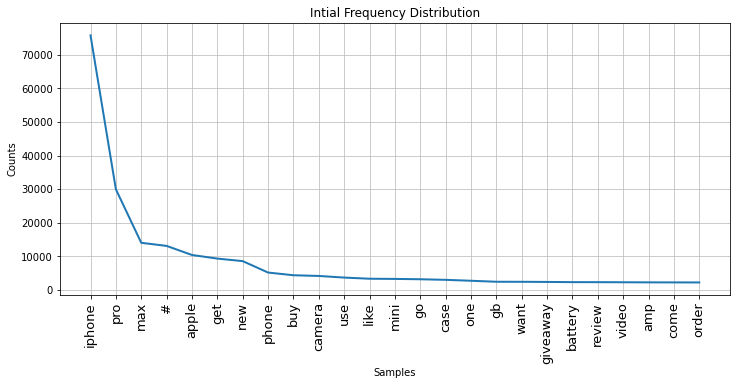

<AxesSubplot:title={'center':'Intial Frequency Distribution'}, xlabel='Samples', ylabel='Counts'>

In [22]:
# Plot word frequency distribution of first few words

plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
plt.title('Intial Frequency Distribution')
freq_dist = nltk.FreqDist(all_words_list)
freq_dist.plot(25,cumulative=False)

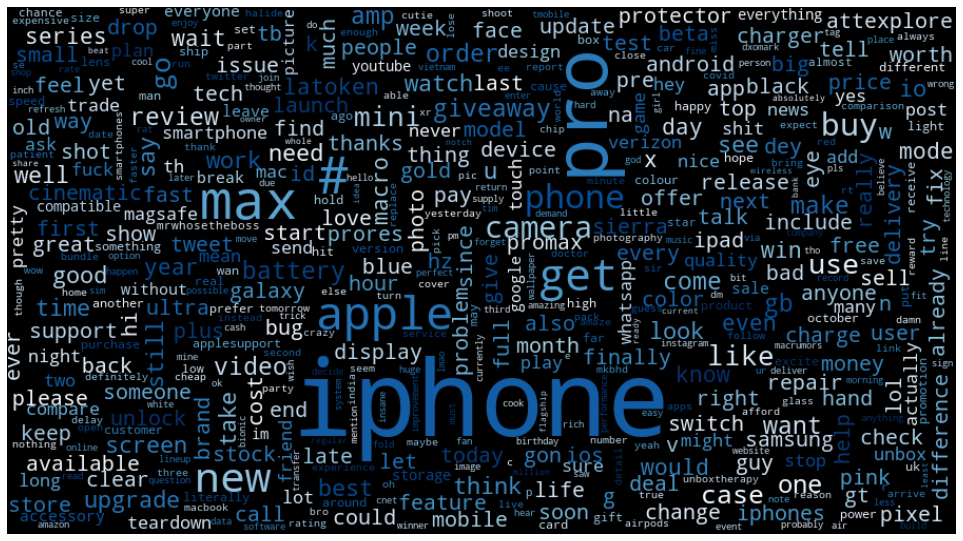

In [23]:
# Word Cloud with word frequencies

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(freq_dist)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
# Remove iphone, apple, q, and #

def finish_cleaning(dataframe):
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('iphone',''))
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('apple',''))
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('q',''))
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('#',''))

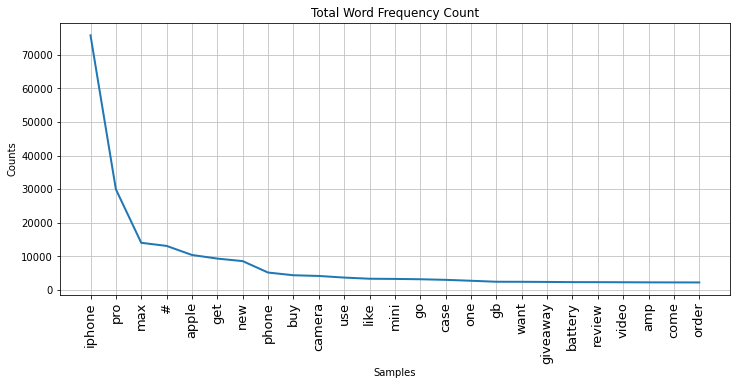

<AxesSubplot:title={'center':'Total Word Frequency Count'}, xlabel='Samples', ylabel='Counts'>

In [25]:
# Join all the tweets into a single string
all_words_string = ' '.join([tweet for tweet in tweets.clean_tweet])

# Make a list of all the words in the dataframe
all_words_list = all_words_string.split()

# Plot word frequency distribution of first few words

plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
plt.title('Total Word Frequency Count')
freq_dist = nltk.FreqDist(all_words_list)
freq_dist.plot(25,cumulative=False)

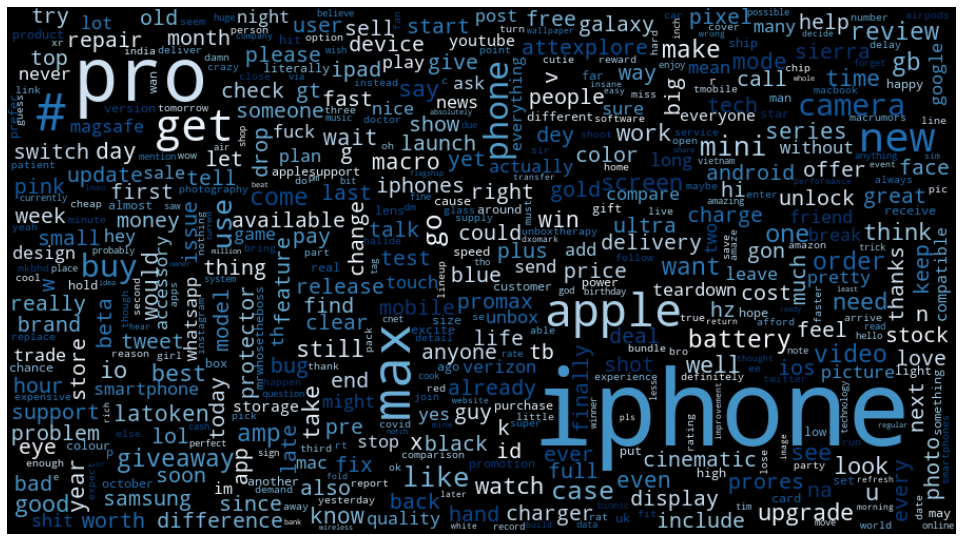

In [26]:
# Word Cloud with word frequencies

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(freq_dist)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
# Remove iphone, apple, q, and #

def finish_cleaning(dataframe):
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('iphone',''))
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('apple',''))
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('q',''))
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('#',''))

In [28]:
finish_cleaning(tweets)

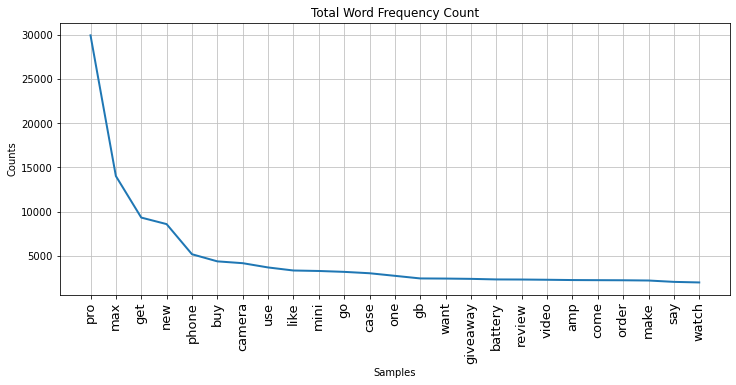

<AxesSubplot:title={'center':'Total Word Frequency Count'}, xlabel='Samples', ylabel='Counts'>

In [29]:
# Join all the tweets into a single string
all_words_string = ' '.join([tweet for tweet in tweets.clean_tweet])

# Make a list of all the words in the dataframe
all_words_list = all_words_string.split()

# Plot word frequency distribution of first few words

plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
plt.title('Total Word Frequency Count')
freq_dist = nltk.FreqDist(all_words_list)
freq_dist.plot(25,cumulative=False)

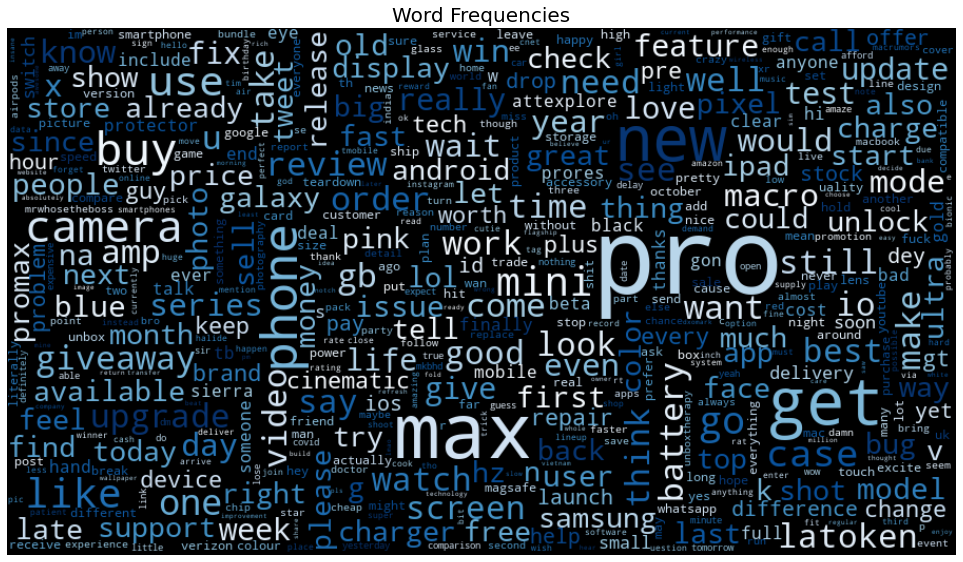

In [30]:
# Word Cloud with word frequencies

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(freq_dist)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Frequencies', fontsize=20)
plt.show()

In [31]:
word_freq = nltk.FreqDist(all_words_list)
freq_df = pd.DataFrame({'Word': list(word_freq.keys()), 'Count': list(word_freq.values())}).sort_values(by=['Count'], ascending=False)
freq_df.head(10)

Word  Count
18      pro  29969
19      max  14031
10      get   9328
104     new   8587
12    phone   5175
17      buy   4368
375  camera   4161
72      use   3678
44     like   3332
46     mini   3278

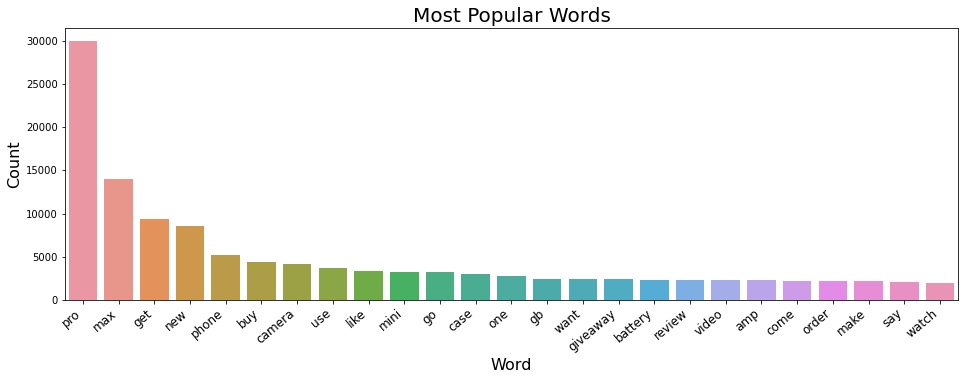

In [32]:
freq_df = freq_df.nlargest(columns="Count", n = 25) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=freq_df, x= "Word", y = "Count")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Word', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Most Popular Words", fontsize=20)
plt.show()

Dataframe grouping the number of tweets by hour of the day

In [33]:
hour_df = pd.DataFrame(tweets.groupby(tweets['date_time'].dt.hour)['clean_tweet'].count()).reset_index()
hour_df = hour_df.rename(columns={'date_time': 'Hour', 'clean_tweet': 'Count'})
hour_df.Hour = hour_df.Hour.replace([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0], ['12:00 AM', '1:00 AM', '2:00 AM', '3:00 AM', '4:00 AM', '5:00 AM', '6:00 AM', '7:00 AM', '8:00 AM', '9:00 AM', '10:00 AM', '11:00 AM', '12:00 AM', '1:00 PM', '2:00 PM', '3:00 PM', '4:00 PM', '5:00 PM', '6:00 PM', '7:00 PM', '8:00 PM', '9:00 PM', '10:00 PM', '11:00 PM'])
hour_df

Hour  Count
0   12:00 AM   2005
1    1:00 AM   1917
2    2:00 AM   2015
3    3:00 AM   2839
4    4:00 AM   2507
5    5:00 AM   2728
6    6:00 AM   2791
7    7:00 AM   3068
8    8:00 AM   3494
9    9:00 AM   3838
10  10:00 AM   3502
11  11:00 AM   3542
12  12:00 AM   3764
13   1:00 PM   3757
14   2:00 PM   3489
15   3:00 PM   3130
16   4:00 PM   2789
17   5:00 PM   2470
18   6:00 PM   2080
19   7:00 PM   1862
20   8:00 PM   1488
21   9:00 PM   1547
22  10:00 PM   1733
23  11:00 PM   1423

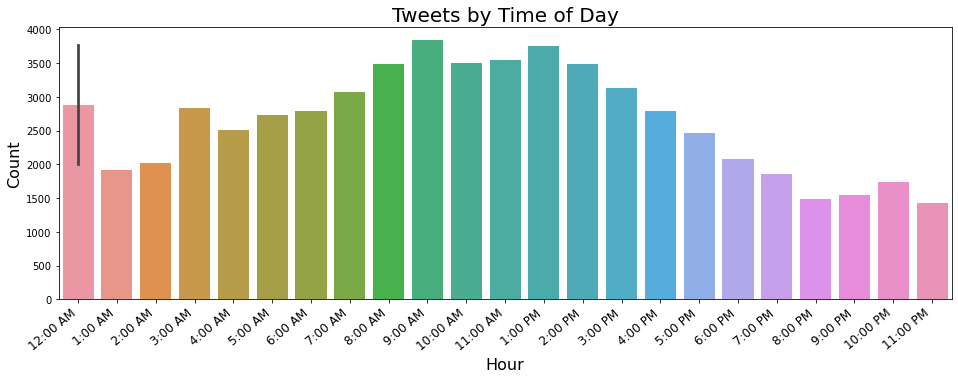

In [34]:
plt.figure(figsize=(16,5))
ax = sns.barplot(data=hour_df, x= "Hour", y = "Count")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Hour', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Tweets by Time of Day", fontsize=20)
plt.show()

Dataframe grouping the number of tweets by day

In [35]:
weekday_df = pd.DataFrame(tweets.groupby(tweets['date_time'].dt.weekday)['clean_tweet'].count()).reset_index()
weekday_df = weekday_df.rename(columns={'date_time': 'Day', 'clean_tweet': 'Count'})
weekday_df.Day = weekday_df.Day.replace([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
weekday_df

Day  Count
0     Monday   6764
1    Tuesday  11578
2  Wednesday  13502
3   Thursday  10575
4     Friday   8698
5   Saturday   6876
6     Sunday   5785

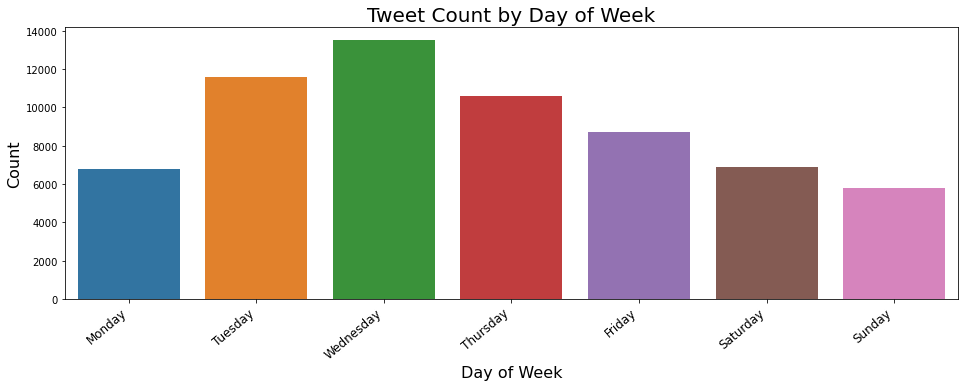

In [36]:
# Plot histogram of Tweet Counts by Day

plt.figure(figsize=(16,5))
ax = sns.barplot(data=weekday_df, x= "Day", y = "Count")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Day of Week', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Tweet Count by Day of Week", fontsize=20)
plt.show()

Dataframe grouping the number of tweets by day of the year

In [37]:
day_df = pd.DataFrame(tweets.resample('D', on='date_time')['clean_tweet'].count()).reset_index().sort_values(by='clean_tweet', ascending=False)
day_df = day_df.rename(columns={'date_time': 'Day', 'clean_tweet': 'Count'})
day_df.head()

Day  Count
10 2021-10-06   7490
9  2021-10-05   6874
3  2021-09-29   6012
4  2021-09-30   5366
5  2021-10-01   5223

In [38]:
top_tweeted_days = day_df.sort_values(by = 'Count', ascending=False)[:25]
top_tweeted_days

Day  Count
10 2021-10-06   7490
9  2021-10-05   6874
3  2021-09-29   6012
4  2021-09-30   5366
5  2021-10-01   5223
11 2021-10-07   5209
2  2021-09-28   4704
8  2021-10-04   3972
6  2021-10-02   3783
12 2021-10-08   3475
7  2021-10-03   3373
13 2021-10-09   3093
1  2021-09-27   2792
0  2021-09-26   2412

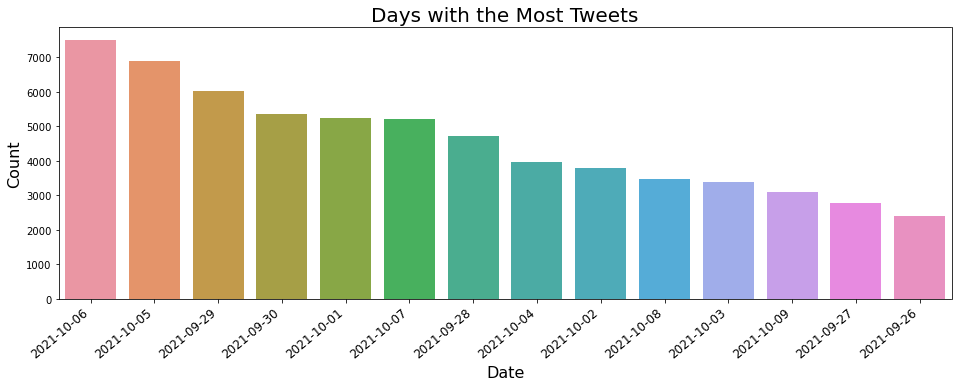

In [39]:
plt.figure(figsize=(16,5))
ax = sns.barplot(data=top_tweeted_days, x= top_tweeted_days.Day.dt.date, y = "Count")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Days with the Most Tweets", fontsize=20)
plt.show()

## VADER Sentiment

In [40]:
df = pd.read_csv('csv/cleaned_tweets.csv').drop(['Unnamed: 0'],axis=1)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63778 entries, 0 to 63777
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           63778 non-null  float64
 1   tweet        63778 non-null  object 
 2   language     63778 non-null  object 
 3   date_time    63778 non-null  object 
 4   clean_tweet  62981 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.4+ MB


In [42]:
df.isna().sum()

id               0
tweet            0
language         0
date_time        0
clean_tweet    797
dtype: int64

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63778 entries, 0 to 63777
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           63778 non-null  float64
 1   tweet        63778 non-null  object 
 2   language     63778 non-null  object 
 3   date_time    63778 non-null  object 
 4   clean_tweet  62981 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.4+ MB


In [44]:
analyzer = SentimentIntensityAnalyzer()

scores = []
for sentence in df['tweet']:
  score = analyzer.polarity_scores(sentence)
  scores.append(score)
  
scores = pd.DataFrame(scores)

df['Compound'] = scores['compound']
df['Negative'] = scores['neg']
df['Neutral'] = scores['neu']
df['Positive'] = scores['pos']
df.head()

id                                              tweet language  \
0  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...       en   
1  1.440000e+18                     I kind of want the iPhone 13 🤔       en   
2  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...       en   
3  1.440000e+18  iphone 13 is another huge distraction from the...       en   
4  1.440000e+18  @TrollTheMagic I know you are going to buy iPh...       en   

             date_time                                        clean_tweet  \
0  2021-09-26 10:23:04                                       tg  giveaway   
1  2021-09-26 10:23:04                                         kind want    
2  2021-09-26 10:22:51                                       tg  giveaway   
3  2021-09-26 10:22:28   another huge distraction enemy well humble ge...   
4  2021-09-26 10:22:09                 trollthemagic know go buy  pro max   

   Compound  Negative  Neutral  Positive  
0    0.0000     0.000    1.000     0.000  
1    0.0772     0.000    0.794     0.206  
2    0.0000     0.000    1.000     0.000  
3   -0.2263     0.251    0.535     0.214  
4    0.0000     0.000    1.000     0.000

In [45]:
sentiment = []

for i in range(len(df)):
  if (df['Compound'][i] < 0):
    sentiment.append("Negative")
  elif (df['Compound'][i] > 0):
    sentiment.append("Positive")
  else:
    sentiment.append("Neutral")
    
sentiment = pd.DataFrame(sentiment)
df['Sentiment'] = sentiment
df.head()

id                                              tweet language  \
0  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...       en   
1  1.440000e+18                     I kind of want the iPhone 13 🤔       en   
2  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...       en   
3  1.440000e+18  iphone 13 is another huge distraction from the...       en   
4  1.440000e+18  @TrollTheMagic I know you are going to buy iPh...       en   

             date_time                                        clean_tweet  \
0  2021-09-26 10:23:04                                       tg  giveaway   
1  2021-09-26 10:23:04                                         kind want    
2  2021-09-26 10:22:51                                       tg  giveaway   
3  2021-09-26 10:22:28   another huge distraction enemy well humble ge...   
4  2021-09-26 10:22:09                 trollthemagic know go buy  pro max   

   Compound  Negative  Neutral  Positive Sentiment  
0    0.0000     0.000    1.000     0.000   Neutral  
1    0.0772     0.000    0.794     0.206  Positive  
2    0.0000     0.000    1.000     0.000   Neutral  
3   -0.2263     0.251    0.535     0.214  Negative  
4    0.0000     0.000    1.000     0.000   Neutral

In [46]:
df.dropna(inplace=True)
df.isna().sum()

id             0
tweet          0
language       0
date_time      0
clean_tweet    0
Compound       0
Negative       0
Neutral        0
Positive       0
Sentiment      0
dtype: int64

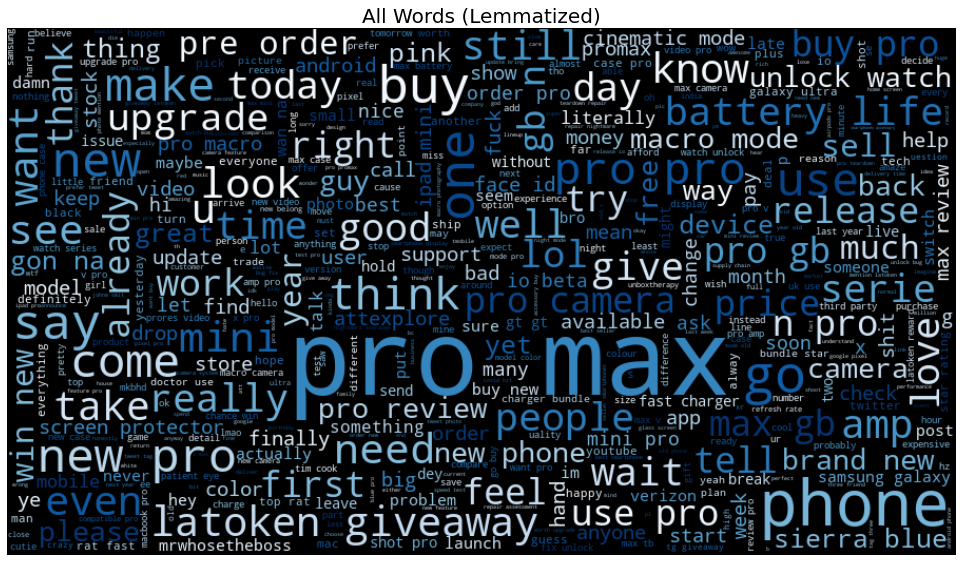

In [47]:
# WordCloud for all words
all_words = ' '.join([text for text in df['clean_tweet']])

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate(all_words)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('All Words (Lemmatized)', fontsize=20)
plt.show()

In [48]:
negative_df = df[df['Sentiment'] == 'Negative']

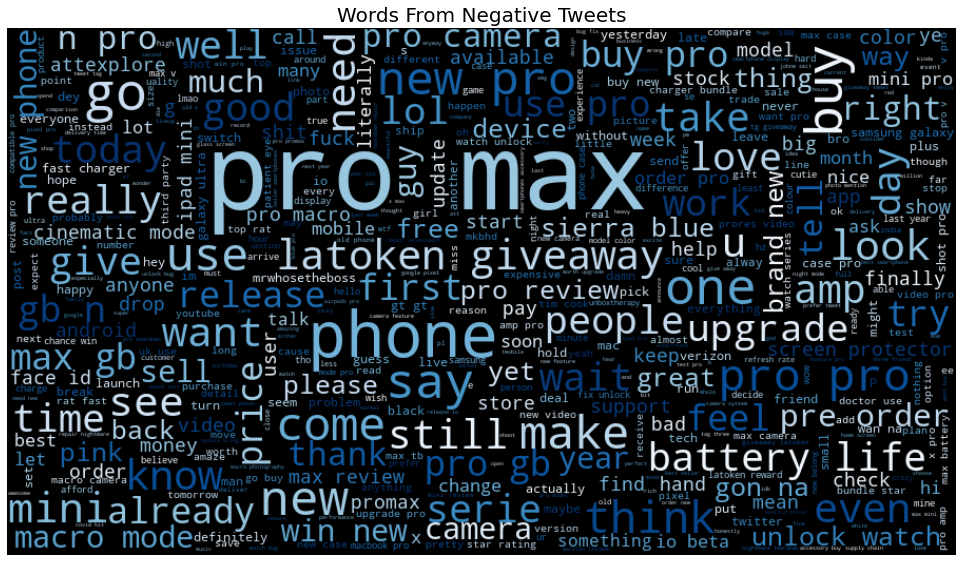

In [49]:
negative_words = ' '.join([text for text in negative_df['clean_tweet']])

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate(all_words)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Words From Negative Tweets', fontsize=20)
plt.show()

In [50]:
positive_df = df[df['Sentiment'] == 'Positive']

In [51]:
positive_df.head()

id                                              tweet language  \
1   1.440000e+18                     I kind of want the iPhone 13 🤔       en   
9   1.440000e+18  Apple will fix iPhone 13 'Unlock with Apple Wa...       en   
11  1.440000e+18  iPhone 13 Unboxing 💙   Let’s see if this video...       en   
14  1.440000e+18  @TmarTn  I hope with this giveaway and much mo...       en   
19  1.440000e+18  Apple company shares crashes after iPhone 13 a...       en   

              date_time                                        clean_tweet  \
1   2021-09-26 10:23:04                                         kind want    
9   2021-09-26 10:21:33   fix  unlock  watch soon day silence sunday  c...   
11  2021-09-26 10:20:59        unboxing let see video well twitter like ig   
14  2021-09-26 10:20:24  tmartn hope giveaway much upcoming channel rea...   
19  2021-09-26 10:19:24                  company share crash  announcement   

    Compound  Negative  Neutral  Positive Sentiment  
1     0.0772     0.000    0.794     0.206  Positive  
9     0.2023     0.038    0.907     0.054  Positive  
11    0.5983     0.000    0.766     0.234  Positive  
14    0.8779     0.000    0.719     0.281  Positive  
19    0.2960     0.000    0.784     0.216  Positive

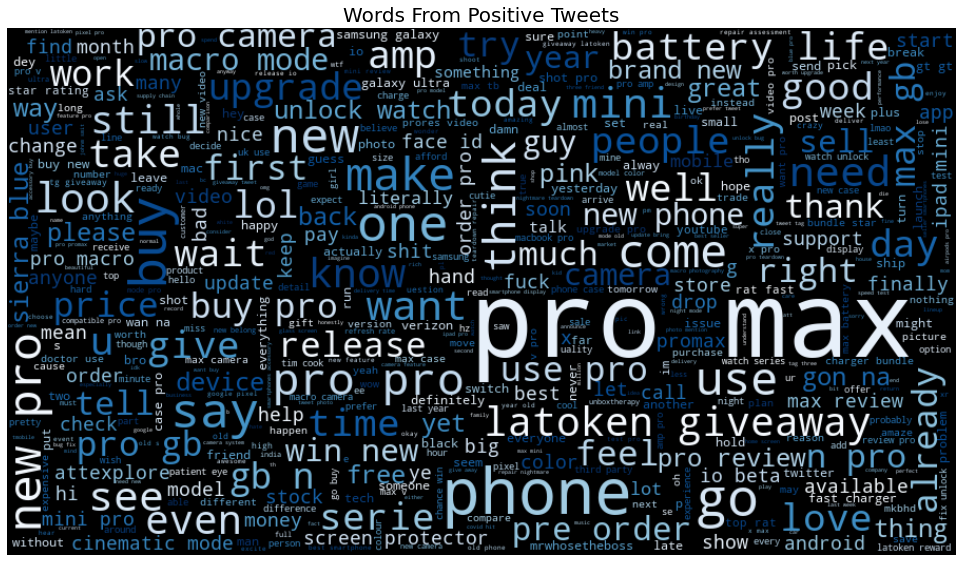

In [52]:
positive_words = ' '.join([text for text in positive_df['clean_tweet']])

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate(all_words)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Words From Positive Tweets', fontsize=20)
plt.show()

In [53]:
df = pd.read_csv('csv/tweet_sentiment.csv').drop(['Unnamed: 0'],axis=1)

## Modeling

In [54]:
df = df[['tweet', 'clean_tweet', 'Sentiment']]

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62981 entries, 0 to 62980
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        62981 non-null  object
 1   clean_tweet  62981 non-null  object
 2   Sentiment    62981 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [56]:
stop_words = stopwords.words('english')

x = df['clean_tweet']
y = df['Sentiment']

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=16)

In [58]:
vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern='[a-zA-Z0-9]+')
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [59]:
objects = [LogisticRegression(fit_intercept=False, C=1e12, solver='saga'), 
           Pipeline([('ss', StandardScaler(with_mean=False)), ('knn', KNeighborsClassifier())]),
           Pipeline([('bz', Binarizer()), ('bayes', MultinomialNB())]),
           Pipeline([('ss', StandardScaler(with_mean=False)), ('svm', SVC())]),
           DecisionTreeClassifier(), 
           RandomForestClassifier(), 
           GradientBoostingClassifier(),
           AdaBoostClassifier(),
           XGBClassifier(),
           CatBoostClassifier(verbose=False)]
index = ['Logistic Regression', 'Nearest Neighbors', 'Naive Bayes', 'SVM', 
         'Decision Tree', 'Random Forest', 'Gradient Boost', 'AdaBoost', 'XGBoost', 'CatBoost']

Logistic Regression Results:


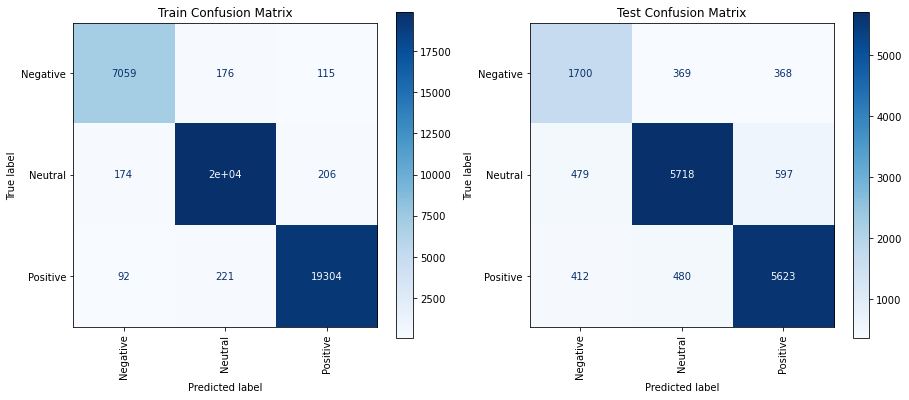

              precision    recall  f1-score   support

    Negative       0.66      0.70      0.68      2437
     Neutral       0.87      0.84      0.86      6794
    Positive       0.85      0.86      0.86      6515

    accuracy                           0.83     15746
   macro avg       0.79      0.80      0.80     15746
weighted avg       0.83      0.83      0.83     15746



Nearest Neighbors Results:


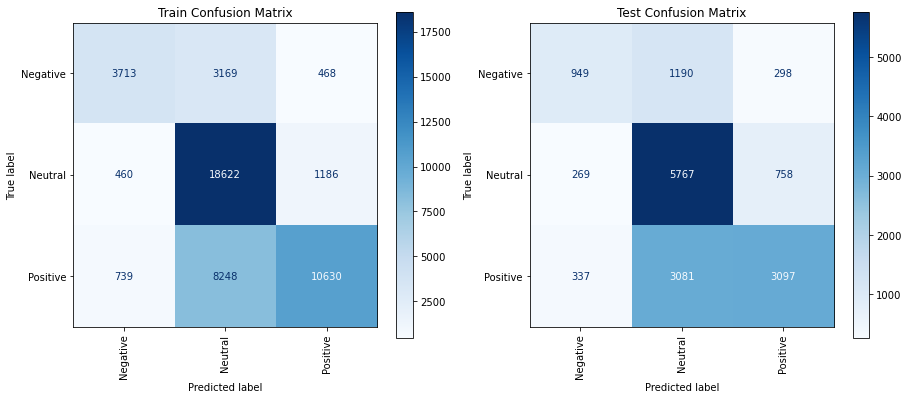

              precision    recall  f1-score   support

    Negative       0.61      0.39      0.48      2437
     Neutral       0.57      0.85      0.69      6794
    Positive       0.75      0.48      0.58      6515

    accuracy                           0.62     15746
   macro avg       0.64      0.57      0.58     15746
weighted avg       0.65      0.62      0.61     15746



Naive Bayes Results:


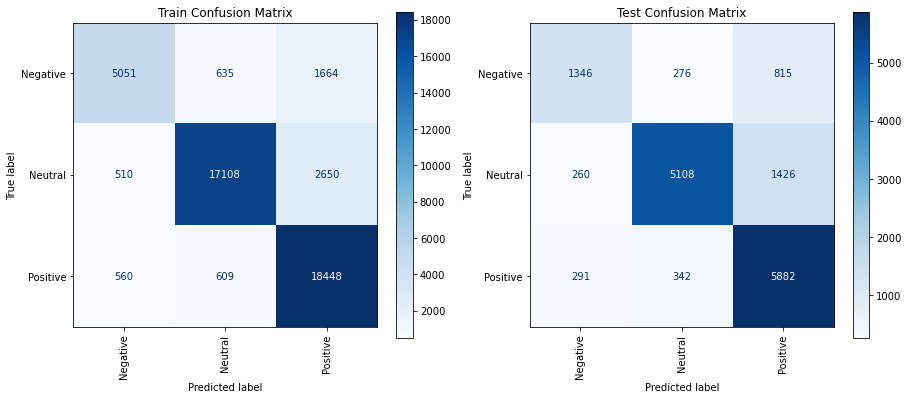

              precision    recall  f1-score   support

    Negative       0.71      0.55      0.62      2437
     Neutral       0.89      0.75      0.82      6794
    Positive       0.72      0.90      0.80      6515

    accuracy                           0.78     15746
   macro avg       0.78      0.74      0.75     15746
weighted avg       0.79      0.78      0.78     15746



SVM Results:


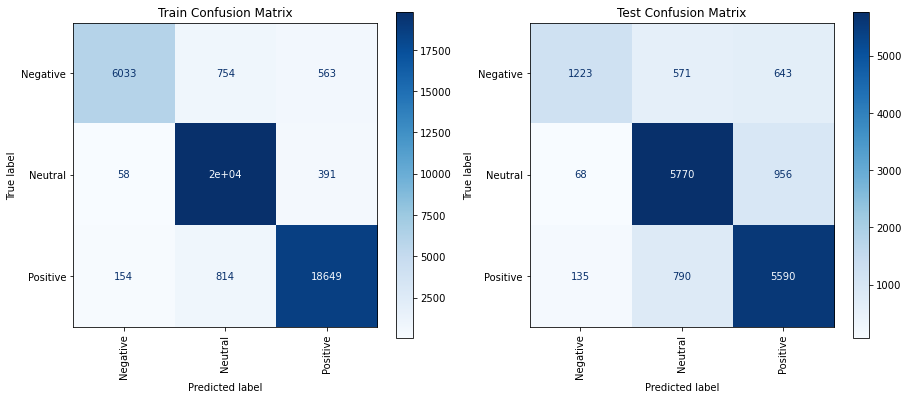

              precision    recall  f1-score   support

    Negative       0.86      0.50      0.63      2437
     Neutral       0.81      0.85      0.83      6794
    Positive       0.78      0.86      0.82      6515

    accuracy                           0.80     15746
   macro avg       0.81      0.74      0.76     15746
weighted avg       0.80      0.80      0.79     15746



Decision Tree Results:


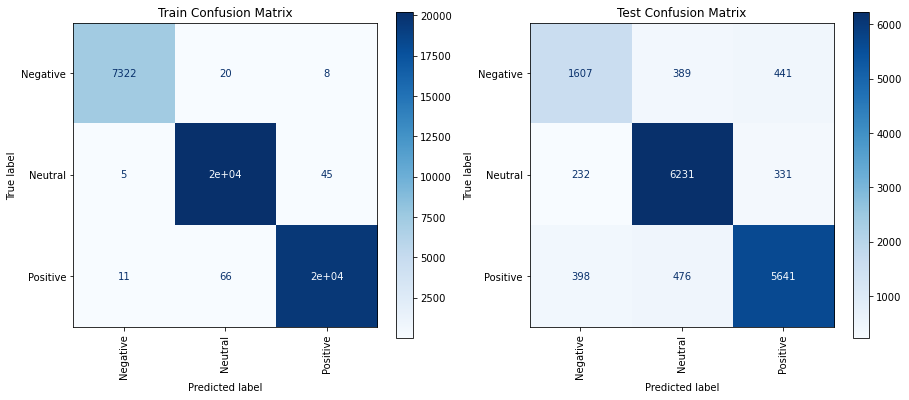

              precision    recall  f1-score   support

    Negative       0.72      0.66      0.69      2437
     Neutral       0.88      0.92      0.90      6794
    Positive       0.88      0.87      0.87      6515

    accuracy                           0.86     15746
   macro avg       0.83      0.81      0.82     15746
weighted avg       0.85      0.86      0.85     15746



Random Forest Results:


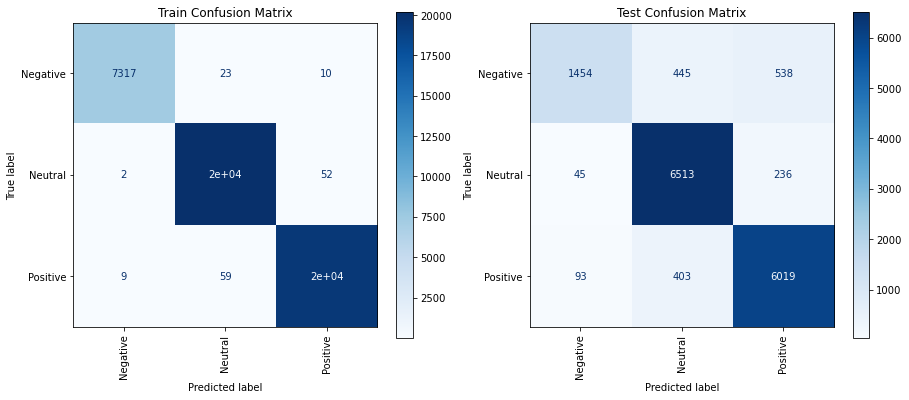

              precision    recall  f1-score   support

    Negative       0.91      0.60      0.72      2437
     Neutral       0.88      0.96      0.92      6794
    Positive       0.89      0.92      0.90      6515

    accuracy                           0.89     15746
   macro avg       0.89      0.83      0.85     15746
weighted avg       0.89      0.89      0.88     15746



Gradient Boost Results:


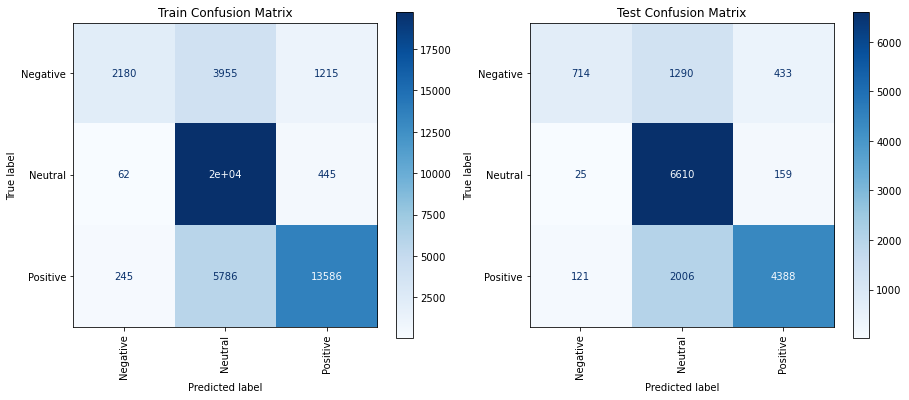

              precision    recall  f1-score   support

    Negative       0.83      0.29      0.43      2437
     Neutral       0.67      0.97      0.79      6794
    Positive       0.88      0.67      0.76      6515

    accuracy                           0.74     15746
   macro avg       0.79      0.65      0.66     15746
weighted avg       0.78      0.74      0.72     15746



AdaBoost Results:


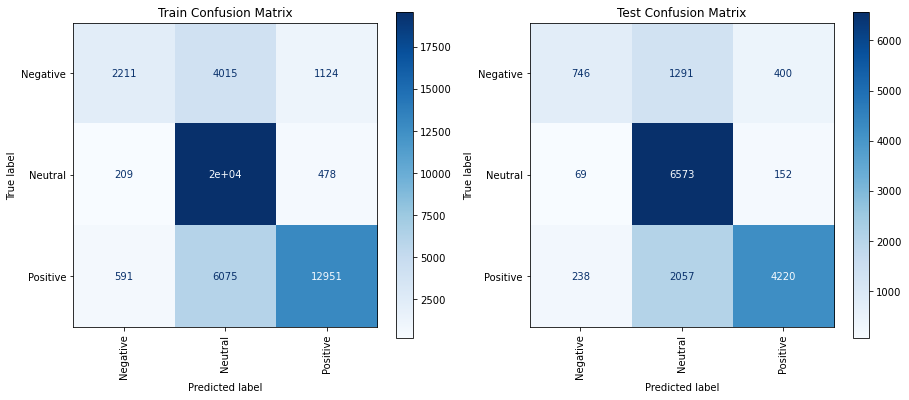

              precision    recall  f1-score   support

    Negative       0.71      0.31      0.43      2437
     Neutral       0.66      0.97      0.79      6794
    Positive       0.88      0.65      0.75      6515

    accuracy                           0.73     15746
   macro avg       0.75      0.64      0.65     15746
weighted avg       0.76      0.73      0.71     15746



XGBoost Results:
[13:11:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


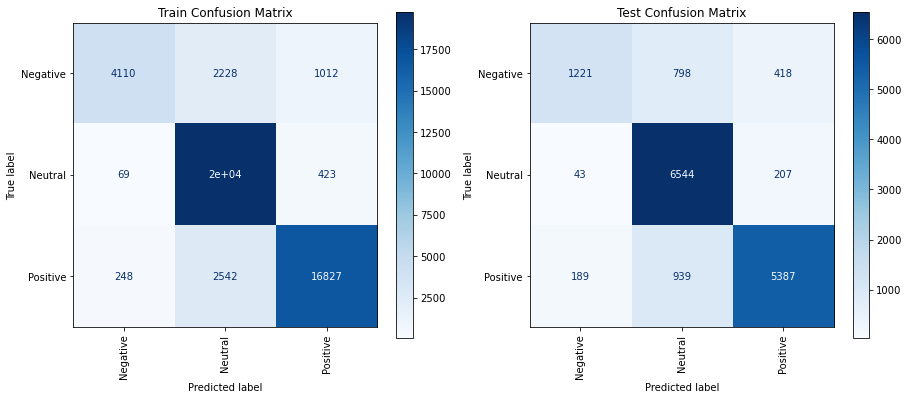

              precision    recall  f1-score   support

    Negative       0.84      0.50      0.63      2437
     Neutral       0.79      0.96      0.87      6794
    Positive       0.90      0.83      0.86      6515

    accuracy                           0.84     15746
   macro avg       0.84      0.76      0.79     15746
weighted avg       0.84      0.84      0.83     15746



CatBoost Results:


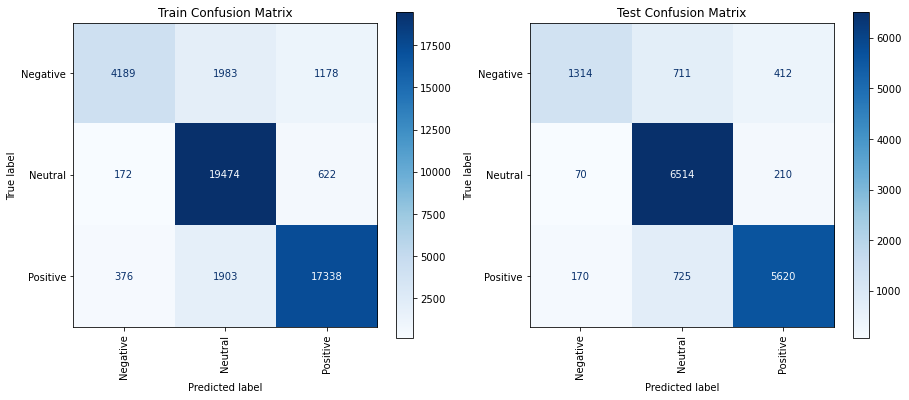

              precision    recall  f1-score   support

    Negative       0.85      0.54      0.66      2437
     Neutral       0.82      0.96      0.88      6794
    Positive       0.90      0.86      0.88      6515

    accuracy                           0.85     15746
   macro avg       0.86      0.79      0.81     15746
weighted avg       0.86      0.85      0.85     15746





The model with the highest precision score is Random Forest.
The model with the highest recall score is Random Forest.
The model with the highest accuracy score is Random Forest.
The model with the highest F1 score is Random Forest.


In [60]:
models = m(x_train, x_test, y_train, y_test, objects=objects, index=index)

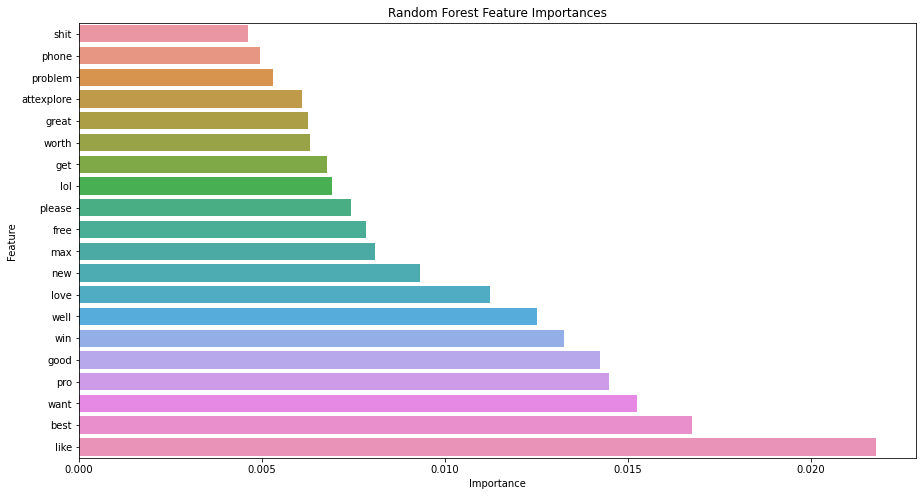

In [61]:
importances = sorted(list(zip(models[5].feature_importances_, vectorizer.get_feature_names())))[-20:]
plot = pd.DataFrame(importances, columns=['Importance', 'Feature'])

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=plot, y='Feature', x='Importance')
ax.set_title(f'{index[5]} Feature Importances')
plt.show();

In [62]:
words_dict = dict(zip(vectorizer.get_feature_names(), models[5].feature_importances_))

In [63]:
words_dict

{'aa': 2.410289260767406e-05,
 'aaa': 1.8972493148041318e-05,
 'aaaaa': 5.265421249064036e-06,
 'aaaaaaaa': 9.781647051749394e-10,
 'aaaaaaaaaa': 5.270036132322941e-07,
 'aaaaaahhhh': 1.8488555146145954e-06,
 'aaaaand': 2.1856549531694396e-10,
 'aaaaat': 3.2288151987708125e-06,
 'aaaahhh': 8.791659852672325e-07,
 'aaaamhim': 1.6460521766464167e-06,
 'aaaggh': 4.538291421669117e-08,
 'aaalllennnndjsj': 3.232829237673296e-09,
 'aabidahcrayola': 1.522749699992554e-09,
 'aachen': 2.2676424362880347e-06,
 'aadh': 1.0976334830976434e-10,
 'aadiiii': 3.450731410193043e-11,
 'aadilba': 3.110616457609071e-07,
 'aagaya': 4.391200829300664e-08,
 'aagazette': 3.166928599512587e-08,
 'aah': 3.920479069234279e-08,
 'aahe': 3.0171638885615278e-06,
 'aahh': 1.8244549127774678e-06,
 'aahhh': 2.074053256060533e-06,
 'aail': 2.8547075945366416e-08,
 'aaj': 1.7539915459100831e-06,
 'aaja': 0.0,
 'aam': 2.901494798198425e-06,
 'aamaanil': 3.3984711518277777e-09,
 'aameen': 1.2501238986073653e-07,
 'aamiin'

In [64]:
features_dict = dict((k, words_dict[k]) for k in ['battery', 'display', 'camera', 'pro', 'max', 'price', 'upgrade', 'color', 'screen'] if k in words_dict)

In [65]:
features_dict

{'battery': 0.0028917027360818863,
 'display': 0.0010895300816752458,
 'camera': 0.0031043655099831204,
 'pro': 0.014477336045582245,
 'max': 0.008080614757552243,
 'price': 0.0009399781625483261,
 'upgrade': 0.00209460478353273,
 'color': 0.0008269812671044977,
 'screen': 0.001534215812539693}

In [66]:
features_df = pd.DataFrame(list(features_dict.items()), columns=['Feature', 'Importances'])

In [67]:
features_df

Feature  Importances
0  battery     0.002892
1  display     0.001090
2   camera     0.003104
3      pro     0.014477
4      max     0.008081
5    price     0.000940
6  upgrade     0.002095
7    color     0.000827
8   screen     0.001534

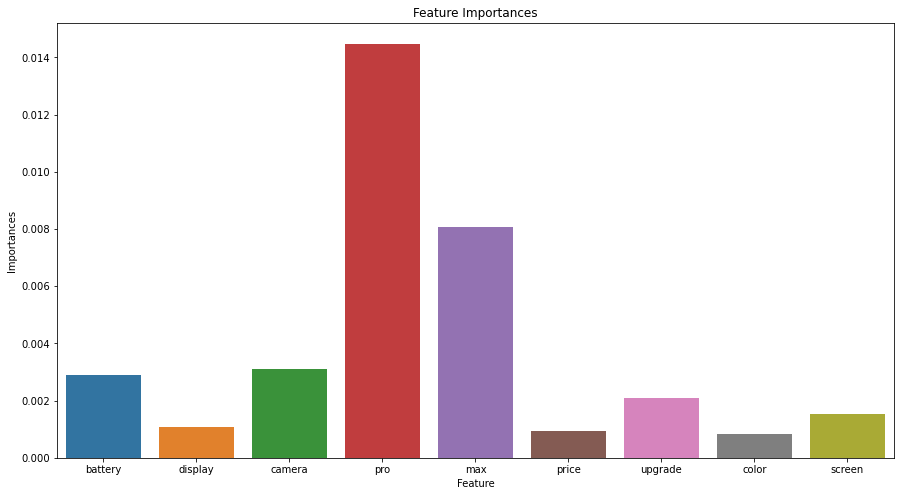

In [68]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=features_df, y='Importances', x='Feature')
ax.set_title('Feature Importances')
plt.show();

In [69]:
selected_words = ['battery', 'display', 'camera', 'pro', 'max', 'price', 'upgrade', 'color', 'screen']

In [70]:
positive_words_string = ' '.join([tweet for tweet in positive_df.clean_tweet])
positive_words_list = positive_words_string.split()

In [71]:
positive_words_list

['kind',
 'want',
 'fix',
 'unlock',
 'watch',
 'soon',
 'day',
 'silence',
 'sunday',
 'confirm',
 'unlock',
 'watch',
 'feature',
 'fix',
 'software',
 'patch',
 'support',
 'document',
 'publish',
 'sunday',
 'confirm',
 'issue',
 'limit',
 'unboxing',
 'let',
 'see',
 'video',
 'well',
 'twitter',
 'like',
 'ig',
 'tmartn',
 'hope',
 'giveaway',
 'much',
 'upcoming',
 'channel',
 'reach',
 'many',
 'people',
 'become',
 'part',
 'community',
 'well',
 'good',
 'luck',
 'everyone',
 'pro',
 'max',
 'company',
 'share',
 'crash',
 'announcement',
 'ok',
 'mean',
 'old',
 'model',
 'get',
 'cheap',
 'dog',
 'awesome',
 'normally',
 'run',
 'well',
 'almost',
 'device',
 'recently',
 'go',
 'full',
 'public',
 'release',
 'wait',
 'new',
 'pro',
 'max',
 'new',
 'ipad',
 'mini',
 'sixth',
 'generation',
 'use',
 'icloud',
 'backgup',
 'check',
 'order',
 'pro',
 'virginmedia',
 'make',
 'sure',
 'link',
 'broadband',
 'account',
 'order',
 'show',
 'already',
 'customer',
 'virginmobil

In [72]:
positive_dict_counts = Counter(positive_words_list)

In [73]:
positive_output_dict_counts = dict((k, positive_dict_counts[k]) for k in selected_words)

positive_output_dict_counts

{'battery': 1382,
 'display': 580,
 'camera': 2228,
 'pro': 13297,
 'max': 6059,
 'price': 458,
 'upgrade': 1028,
 'color': 558,
 'screen': 989}

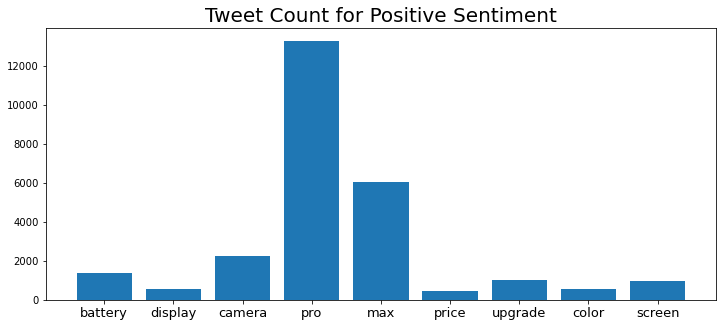

In [74]:
plt.figure(figsize=(12,5))
plt.bar(range(len(positive_output_dict_counts)), positive_output_dict_counts.values(), align='center')
plt.xticks(range(len(positive_output_dict_counts)), list(positive_output_dict_counts.keys()), fontsize=13)
plt.title('Tweet Count for Positive Sentiment', fontsize=20)
plt.show()

In [75]:
negative_words_string = ' '.join([tweet for tweet in negative_df.clean_tweet])
negative_words_list = negative_words_string.split()

In [76]:
negative_words_list

['another',
 'huge',
 'distraction',
 'enemy',
 'well',
 'humble',
 'get',
 'flip',
 'phone',
 'lol',
 'promise',
 'fix',
 'broken',
 'unlock',
 'watch',
 'feature',
 'absolutely',
 'reason',
 'people',
 'buy',
 'cause',
 'really',
 'nothing',
 'promise',
 'fix',
 'broken',
 'unlock',
 'watch',
 'feature',
 'fix',
 'issue',
 'prevent',
 'user',
 'unlock',
 'watch',
 'upcoming',
 'software',
 'update',
 'face',
 'id',
 'stop',
 'work',
 'replace',
 'screen',
 'third',
 'party',
 'repair',
 'video',
 'fix',
 'issue',
 'prevent',
 'user',
 'unlock',
 'watch',
 'upcoming',
 'software',
 'update',
 'could',
 'absolutely',
 'care',
 'less',
 'cinematic',
 'mode',
 'whatever',
 'make',
 'round',
 'shitty',
 'focus',
 'pull',
 'mechanic',
 'cap',
 'p',
 'rendersbyian',
 'mac',
 'joseadorno',
 'real',
 'design',
 'buy',
 'second',
 'come',
 'go',
 'tbh',
 'name',
 'bubblepins',
 'get',
 'black',
 'pro',
 'fit',
 'color',
 'soul',
 'fix',
 'issue',
 'prevent',
 'user',
 'unlock',
 'watch',
 'upc

In [77]:
negative_dict_counts = Counter(negative_words_list)

In [78]:
negative_output_dict_counts = dict((k, negative_dict_counts[k]) for k in selected_words)

negative_output_dict_counts

{'battery': 440,
 'display': 147,
 'camera': 579,
 'pro': 3826,
 'max': 1931,
 'price': 189,
 'upgrade': 338,
 'color': 91,
 'screen': 415}

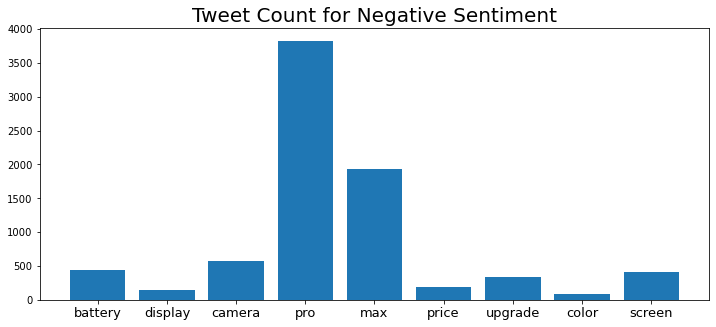

In [79]:
plt.figure(figsize=(12,5))
plt.bar(range(len(negative_output_dict_counts)), negative_output_dict_counts.values(), align='center')
plt.xticks(range(len(negative_output_dict_counts)), list(negative_output_dict_counts.keys()), fontsize=13)
plt.title('Tweet Count for Negative Sentiment', fontsize=20)
plt.show()

In [80]:
df.Sentiment.value_counts()

Neutral     27062
Positive    26132
Negative     9787
Name: Sentiment, dtype: int64

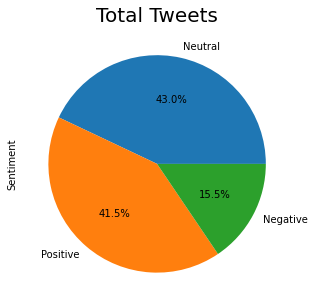

In [81]:
plt.figure(figsize=(12,5))
df['Sentiment'].value_counts().plot(kind='pie', autopct="%.1f%%");
plt.title('Total Tweets', fontsize=20)
plt.show()